# Table of Contents
- [Evaluate cluster tendency](#Evaluate-cluster-tendency) - Hopkins statistic (*) ⚠️
- [The k-means algorithm](#The-k-means-algorithm)
- [External evaluation metrics](#External-evaluation-metrics)



(*) ⚠️ an implementation for the Hopkins statistic is available in python (`pyclustertend`) but it requires version python < 3.10

To properly install pyclustertend you may need to create a novel environment as follows:

```shell
$ conda create --name dmml-clustering python=3.8 
$ conda activate dmml-cluster
(dmml-cluster) $ pip install pyclustertend
(dmml-cluster) $ pip install jupyter
```
    # ... possibly install any other dependency

In this notebook, we just include the src for the hopkins function in the following cell (a bit sloppy).

In [1]:
from typing import Union

import numpy as np
import pandas as pd
from sklearn.neighbors import BallTree


def hopkins(data_frame: Union[np.ndarray, pd.DataFrame], sampling_size: int) -> float:
    """Assess the clusterability of a dataset. A score between 0 and 1, a score around 0.5 express
    no clusterability and a score tending to 0 express a high cluster tendency.

    Examples
    --------
    >>> from sklearn import datasets
    >>> from pyclustertend import hopkins
    >>> X = datasets.load_iris().data
    >>> hopkins(X,150)
    0.16
    """

    if type(data_frame) == np.ndarray:
        data_frame = pd.DataFrame(data_frame)

    data_frame_sample = sample_observation_from_dataset(data_frame, sampling_size)

    sample_distances_to_nearest_neighbours = get_distance_sample_to_nearest_neighbours(
        data_frame, data_frame_sample
    )

    uniformly_selected_observations_df = simulate_df_with_same_variation(
        data_frame, sampling_size
    )

    df_distances_to_nearest_neighbours = get_nearest_sample(
        data_frame, uniformly_selected_observations_df
    )

    x = sum(sample_distances_to_nearest_neighbours)
    y = sum(df_distances_to_nearest_neighbours)

    if x + y == 0:
        raise Exception("The denominator of the hopkins statistics is null")

    return x / (x + y)[0]


def get_nearest_sample(df: pd.DataFrame, uniformly_selected_observations: pd.DataFrame):
    tree = BallTree(df, leaf_size=2)
    dist, _ = tree.query(uniformly_selected_observations, k=1)
    uniformly_df_distances_to_nearest_neighbours = dist
    return uniformly_df_distances_to_nearest_neighbours


def simulate_df_with_same_variation(
    df: pd.DataFrame, sampling_size: int
) -> pd.DataFrame:
    max_data_frame = df.max()
    min_data_frame = df.min()
    uniformly_selected_values_0 = np.random.uniform(
        min_data_frame[0], max_data_frame[0], sampling_size
    )
    uniformly_selected_values_1 = np.random.uniform(
        min_data_frame[1], max_data_frame[1], sampling_size
    )
    uniformly_selected_observations = np.column_stack(
        (uniformly_selected_values_0, uniformly_selected_values_1)
    )
    if len(max_data_frame) >= 2:
        for i in range(2, len(max_data_frame)):
            uniformly_selected_values_i = np.random.uniform(
                min_data_frame[i], max_data_frame[i], sampling_size
            )
            to_stack = (uniformly_selected_observations, uniformly_selected_values_i)
            uniformly_selected_observations = np.column_stack(to_stack)
    uniformly_selected_observations_df = pd.DataFrame(uniformly_selected_observations)
    return uniformly_selected_observations_df


def get_distance_sample_to_nearest_neighbours(df: pd.DataFrame, data_frame_sample):
    tree = BallTree(df, leaf_size=2)
    dist, _ = tree.query(data_frame_sample, k=2)
    data_frame_sample_distances_to_nearest_neighbours = dist[:, 1]
    return data_frame_sample_distances_to_nearest_neighbours


def sample_observation_from_dataset(df, sampling_size: int):
    if sampling_size > df.shape[0]:
        raise Exception("The number of sample of sample is bigger than the shape of D")
    data_frame_sample = df.sample(n=sampling_size)
    return data_frame_sample

In [2]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(
    n_samples = 500,
    n_features = 2,
    centers = 4,
    cluster_std = (1),
    center_box = (-10.0, 10.0),
    shuffle = True,
    random_state = 1, # For reproducibility
)  

## Evaluate cluster tendency

The best way to assess cluster tendency is through visualization (when possible, i.e. dimensionality <= 3)

Is there a cluster tendency? How many clusters are there?

Text(0, 0.5, 'Feature 2')

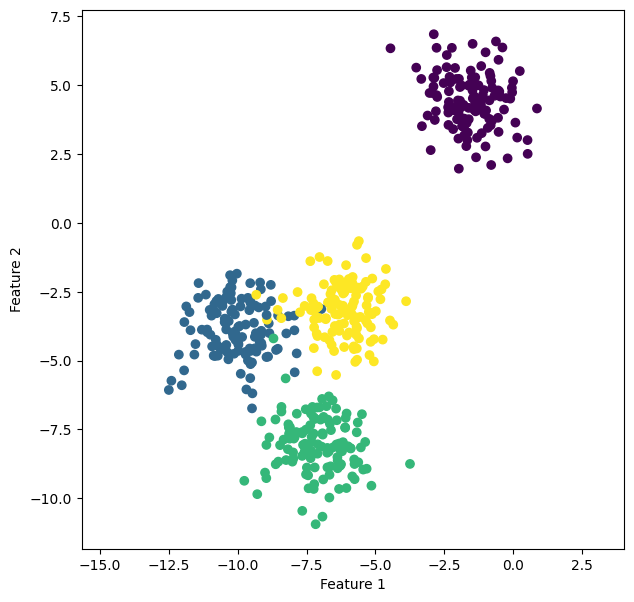

In [3]:
plt.figure(figsize = (7, 7))
plt.scatter(X[:, 0], X[:, 1], c = y)
plt.axis('equal')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

Text(0, 0.5, 'Feature 2')

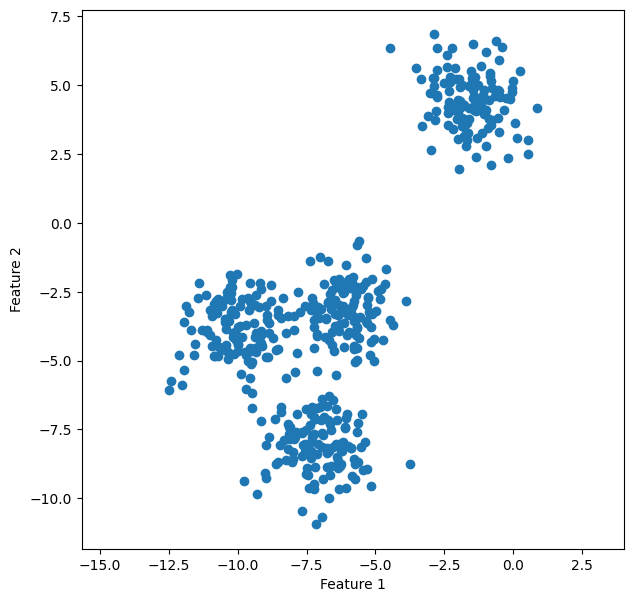

In [4]:
plt.figure(figsize = (7, 7))
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

How many clusters are there?

We can still assess cluster tendency also through the Hopkins statistic.

Look at the docstring of hopkins statistics

In [5]:
hopkins?

Signature:
hopkins(
    data_frame: Union[numpy.ndarray, pandas.core.frame.DataFrame],
    sampling_size: int,
) -> float
Docstring:
Assess the clusterability of a dataset. A score between 0 and 1, a score around 0.5 express
no clusterability and a score tending to 0 express a high cluster tendency.

Examples
--------
>>> from sklearn import datasets
>>> from pyclustertend import hopkins
>>> X = datasets.load_iris().data
>>> hopkins(X,150)
0.16
File:      /var/folders/27/y8zb96dj4rz5c5pd6d84yd440000gn/T/ipykernel_1761/2773690784.py
Type:      function

From theory we would expect that a **value close to 1 tends to express a high cluster tendency**.
- the hopkins statistic should be formulated as follows
```python
[...]
x = sum(data_frame_sample_distances_to_nearest_neighbours)
y = sum(uniformly_df_distances_to_nearest_neighbours)
return y / (x + y)
```
- a value close to 1 is obtained when it holds $x<<y$, and indicates that data do not follow a uniform distribution, but rather a clustering tendency exists.
- *Heuristically, if the statistic is larger than 0.75 it indicates a clustering tendency at 90% confidence level*

**However**, this module refers to a different implementation.
Look at the source code:
    
```python
[...]
x = sum(data_frame_sample_distances_to_nearest_neighbours)
y = sum(uniformly_df_distances_to_nearest_neighbours)
return x / (x + y)
```

In [6]:
for sampling_size in range(10, 51, 10):
    print(f'sampled {sampling_size}: {hopkins(X, sampling_size)}')

sampled 10: 0.11457824205608935
sampled 20: 0.1242445084196098
sampled 30: 0.10061485454252886
sampled 40: 0.09572051211873944
sampled 50: 0.10810604805415462


The low value of H confirms the *cluster* tendency

## The k-means algorithm

In the following we apply the $k$-means algorithm to find groups in the dataset.
Specifically,
- we evaluate the sensitivity of the $k$-means algorithm with respect to its most influential input parameter, that is the number of clusters.
- for each clustering evaluation, we display the clustering result as a scatter plot and compute an internal metric (silhouette score) and the value of the cost function (inertia).
- we analyze the trend of such quantities as a function of the number of clusters.



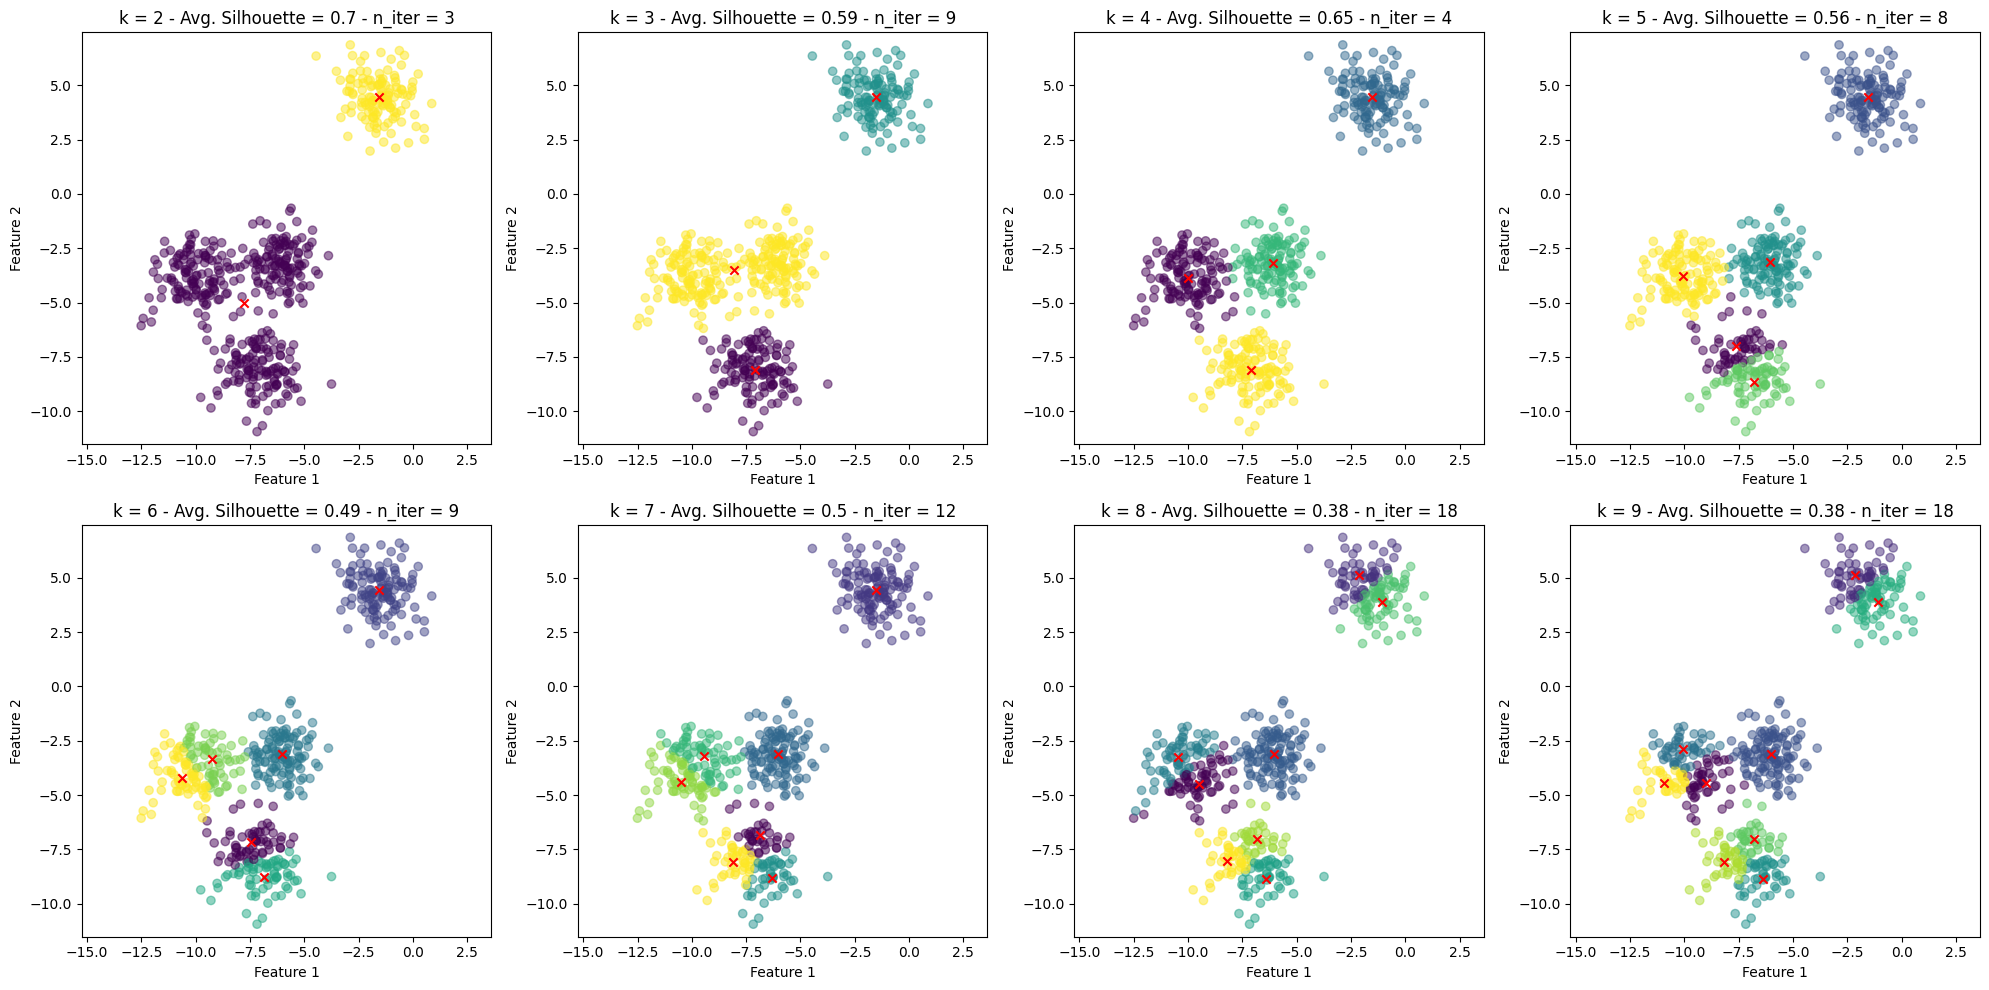

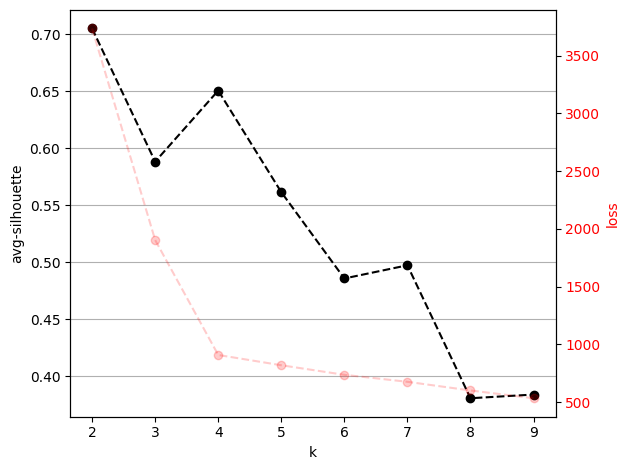

In [7]:
silhouette_list = []
inertia_list = []
f, axes = plt.subplots(2, 4, figsize = (20, 10))
for n_clusters in range(2, 10):
    kmeans = KMeans(n_clusters = n_clusters, random_state = 10, n_init = 'auto')
    y_pred = kmeans.fit_predict(X)
    
    # evaluate silhouette score
    silhouette_avg = silhouette_score(X, y_pred)
    silhouette_list.append(silhouette_avg)

    # evaluate inertia
    inertia = kmeans.inertia_
    inertia_list.append(inertia)
    
    # display clustered samples
    axes[(n_clusters - 2) // 4][(n_clusters - 2) % 4].scatter(X[:, 0], X[:, 1], c = y_pred, alpha = 0.5)
    axes[(n_clusters - 2) // 4][(n_clusters - 2) % 4].axis('equal')
    axes[(n_clusters - 2) // 4][(n_clusters - 2) % 4].set_xlabel('Feature 1')
    axes[(n_clusters - 2) // 4][(n_clusters - 2) % 4].set_ylabel('Feature 2')
    axes[(n_clusters - 2) // 4][(n_clusters - 2) % 4].set_title(f'k = {n_clusters} - Avg. Silhouette = {silhouette_avg:.2} - n_iter = {kmeans.n_iter_}' )

    # display clusters centroids
    centers = kmeans.cluster_centers_
    axes[(n_clusters - 2) // 4][(n_clusters - 2) % 4].scatter(centers[:, 0], centers[:, 1], marker = 'x', c = 'r')
    
plt.tight_layout()

# plot silhouette and inertia trends w.r.t the number of clusters
fig, ax1 = plt.subplots()
ax1.set_xlabel('k')
ax1.set_ylabel('avg-silhouette', color = 'black')
ax1.plot(range(2, 10), silhouette_list, '--ok')
ax1.tick_params(axis = 'y', labelcolor = 'black')
ax1.grid(axis = 'y')

ax2 = ax1.twinx()  
ax2.set_ylabel('loss', color = 'red')  
ax2.plot(range(2, 10), inertia_list, '--or', alpha = 0.2)
ax2.tick_params(axis = 'y', labelcolor = 'red')

plt.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()

### Note-1: What if the two features are on different scales?

The kmeans "inertia" makes the assumption that clusters are convex and isotropic, which is not always the case. It responds poorly to elongated clusters, or manifolds with irregular shapes.

Text(0, 0.5, 'Feature 2')

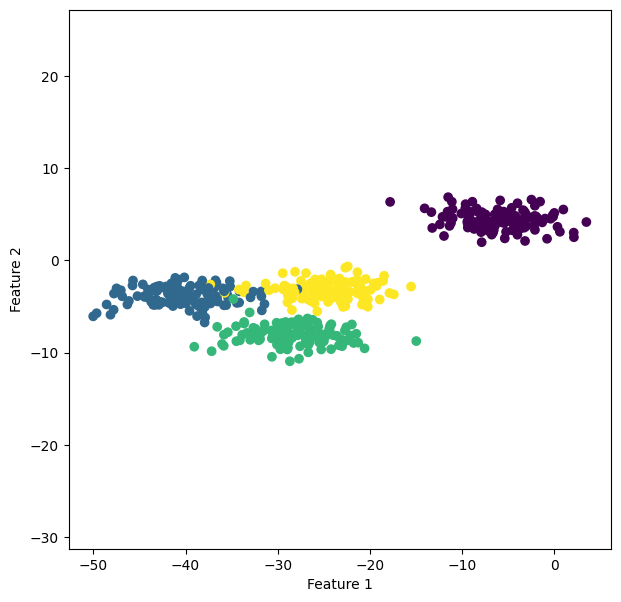

In [8]:
X_aniso = X.copy() * [4, 1]
plt.figure(figsize = (7, 7))
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c = y)
plt.axis('equal') # force equal axes aspect ratio
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

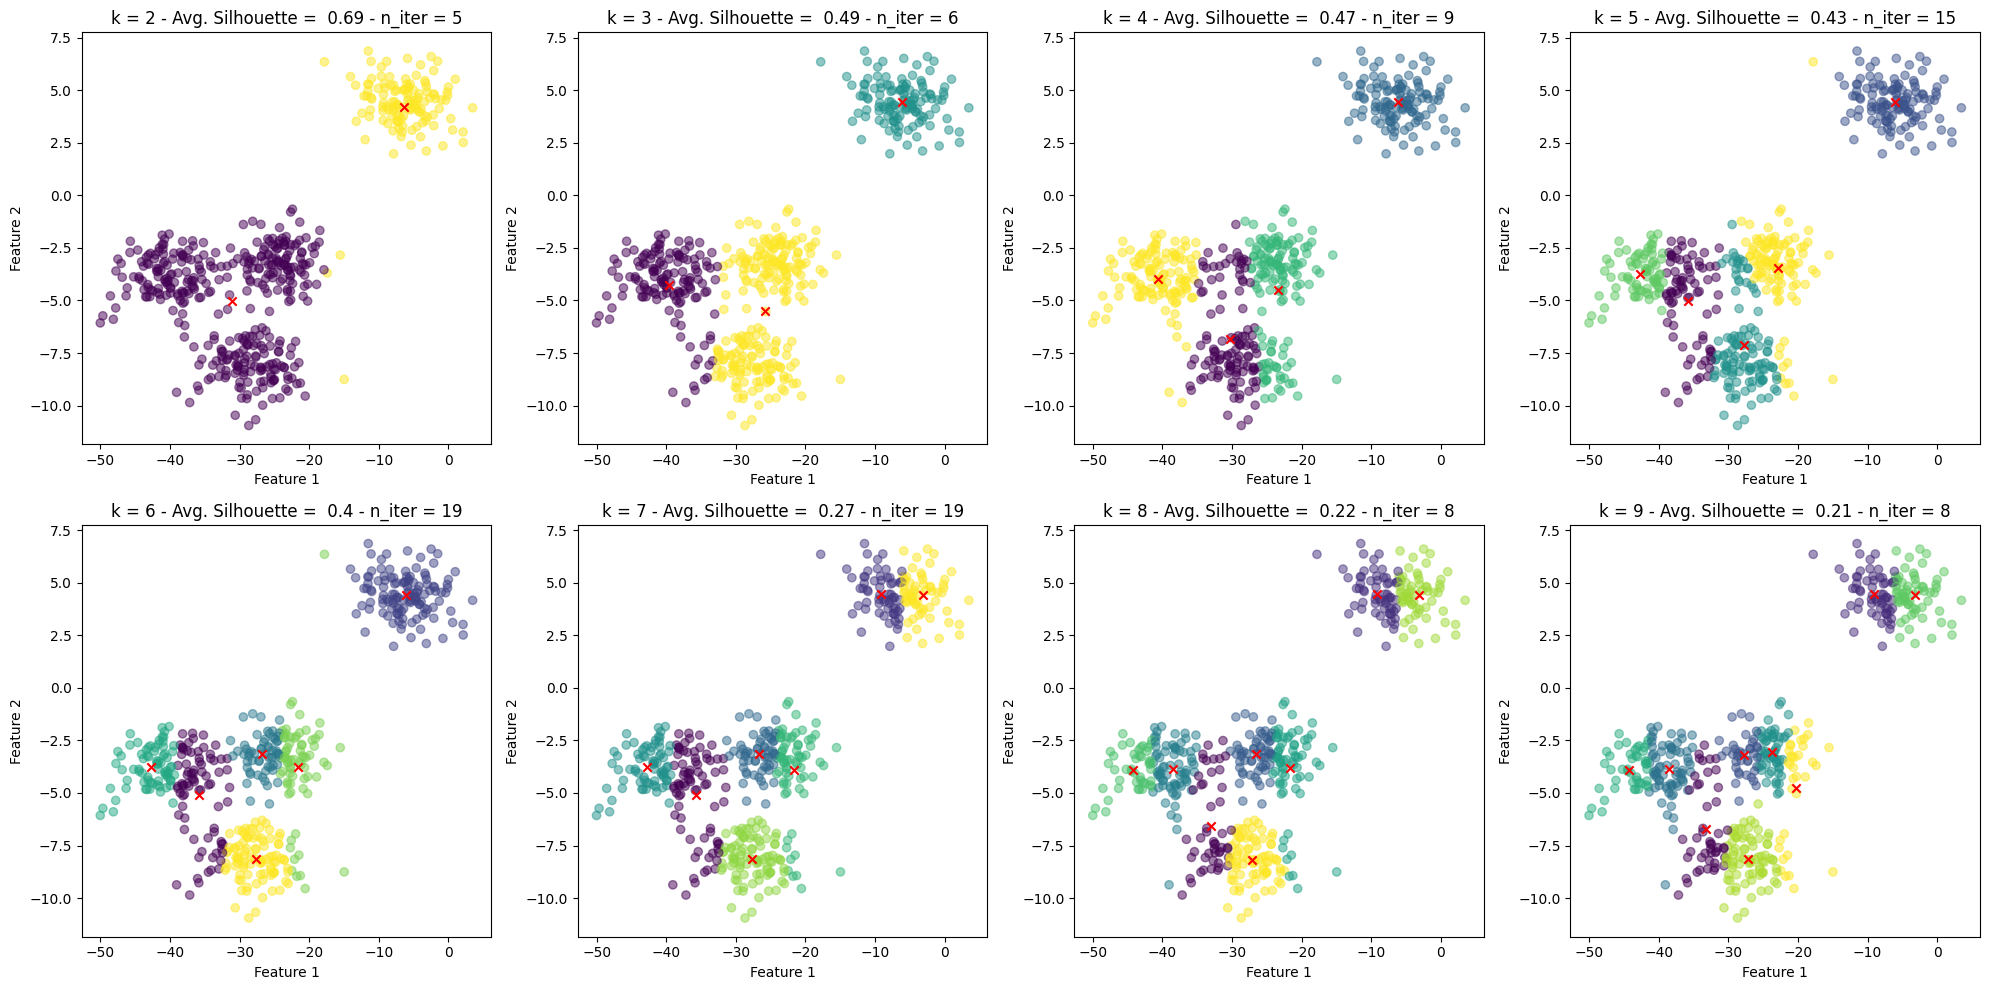

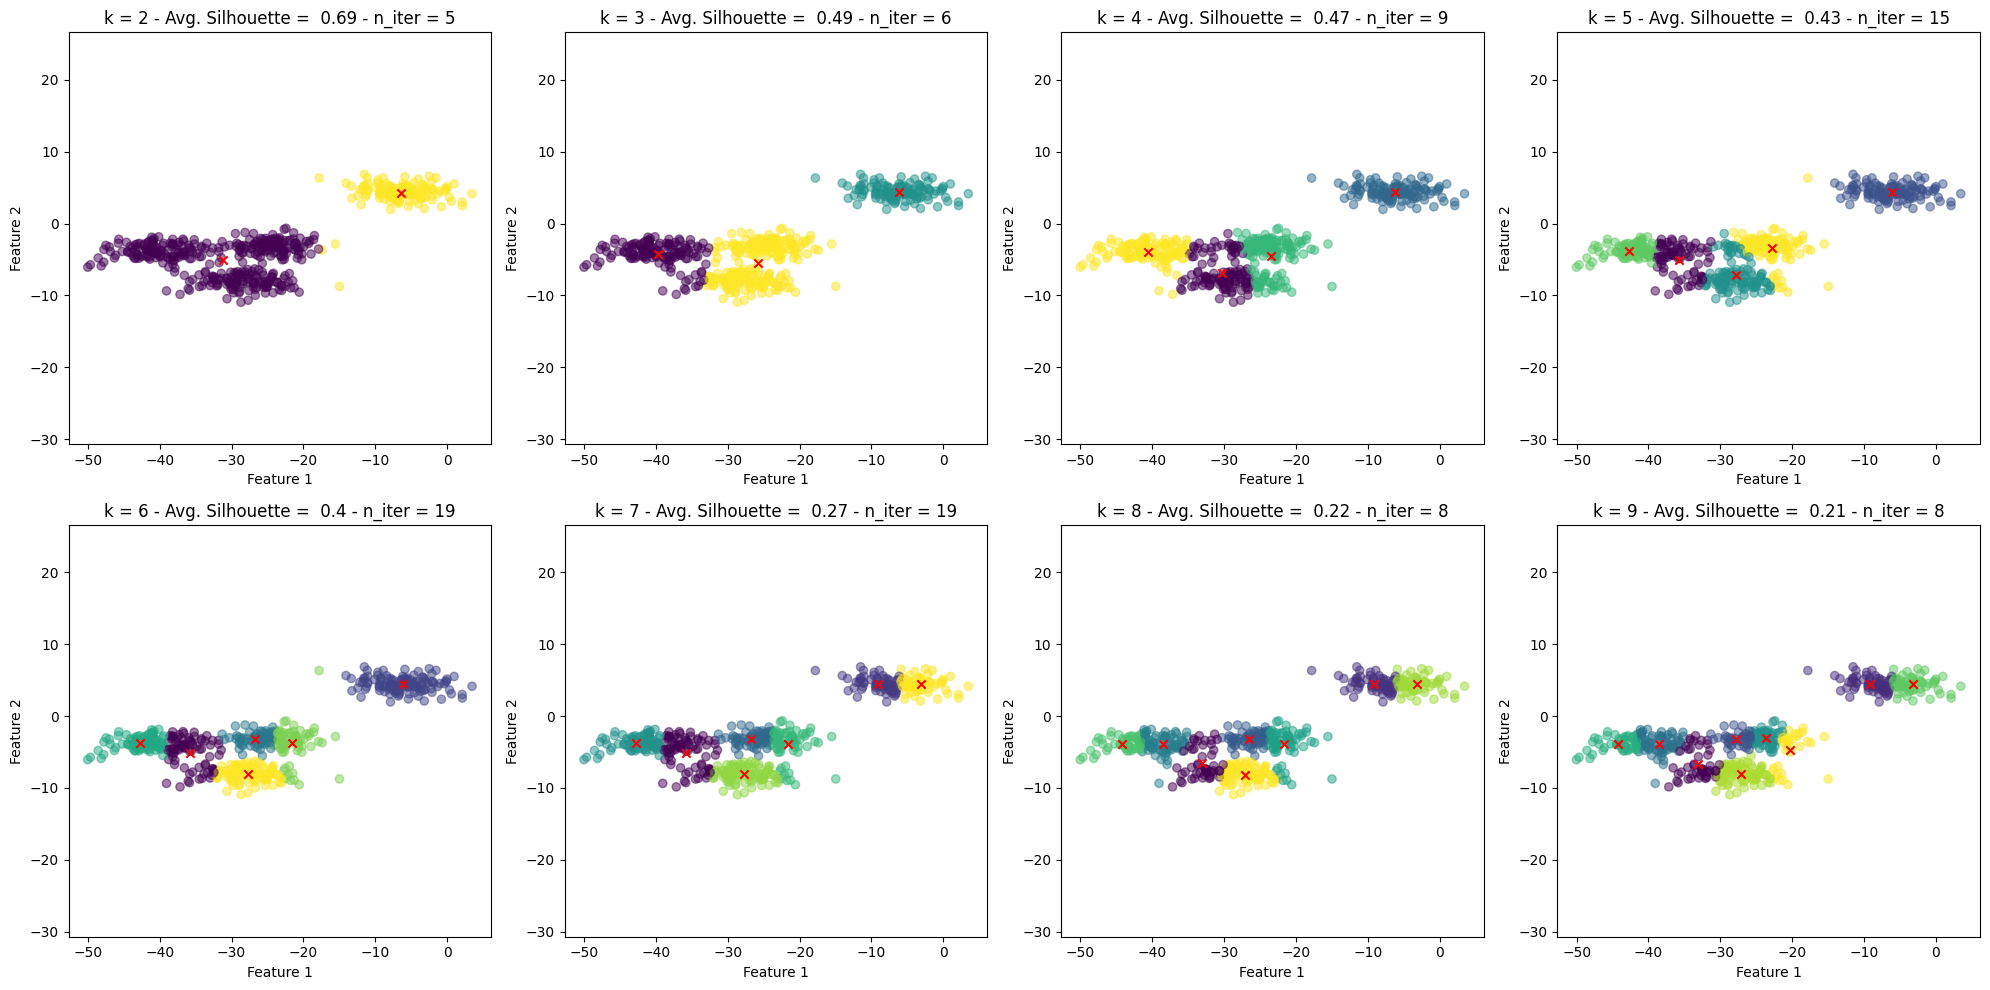

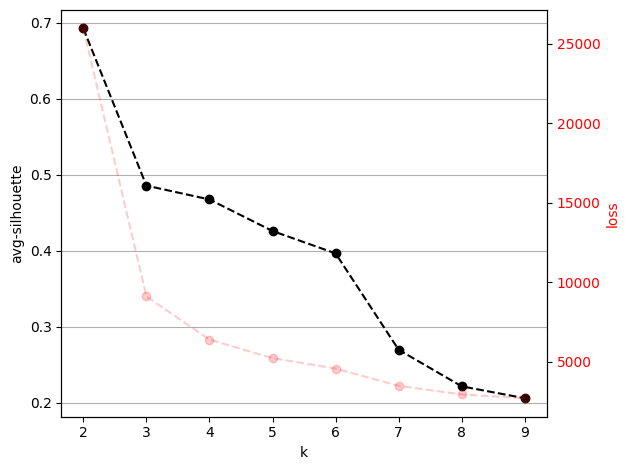

In [9]:
silhouette_list = []
inertia_list = []
f1, axes1 = plt.subplots(2, 4, figsize = (20, 10))
f2, axes2 = plt.subplots(2, 4, figsize = (20, 10))
for n_clusters in range(2, 10):
    kmeans = KMeans(n_clusters = n_clusters, random_state = 10, n_init = 'auto')
    y_pred = kmeans.fit_predict(X_aniso)

    inertia = kmeans.inertia_
    inertia_list.append(inertia)
    
    silhouette_avg = silhouette_score(X, y_pred)
    silhouette_list.append(silhouette_avg)

    centers = kmeans.cluster_centers_

    # NOT force equal axes aspect ratio
    axes1[(n_clusters - 2) // 4][(n_clusters - 2) % 4].scatter(X_aniso[:, 0], X_aniso[:, 1], c = y_pred, alpha = 0.5)
    axes1[(n_clusters - 2) // 4][(n_clusters - 2) % 4].set_xlabel('Feature 1')
    axes1[(n_clusters - 2) // 4][(n_clusters - 2) % 4].set_ylabel('Feature 2')
    axes1[(n_clusters - 2) // 4][(n_clusters - 2) % 4].set_title(f'k = {n_clusters} - Avg. Silhouette = {silhouette_avg: .2} - n_iter = {kmeans.n_iter_}' )
    axes1[(n_clusters - 2) // 4][(n_clusters - 2) % 4].scatter(centers[:, 0], centers[:, 1], marker = 'x', c = 'r')

    
    # force equal axes aspect ratio
    axes2[(n_clusters - 2) // 4][(n_clusters - 2) % 4].scatter(X_aniso[:, 0], X_aniso[:, 1], c = y_pred, alpha = 0.5)
    axes2[(n_clusters - 2) // 4][(n_clusters - 2) % 4].axis('equal')
    axes2[(n_clusters - 2) // 4][(n_clusters - 2) % 4].set_xlabel('Feature 1')
    axes2[(n_clusters - 2) // 4][(n_clusters - 2) % 4].set_ylabel('Feature 2')
    axes2[(n_clusters - 2) // 4][(n_clusters - 2) % 4].set_title(f'k = {n_clusters} - Avg. Silhouette = {silhouette_avg: .2} - n_iter = {kmeans.n_iter_}' )
    axes2[(n_clusters - 2) // 4][(n_clusters - 2) % 4].scatter(centers[:, 0], centers[:, 1], marker = 'x', c = 'r')    
    

f1.set_tight_layout(True)
f2.set_tight_layout(True)

fig, ax1 = plt.subplots()
ax1.set_xlabel('k')
ax1.set_ylabel('avg-silhouette', color = 'black')
ax1.plot(range(2, 10), silhouette_list, '--ok')
ax1.tick_params(axis = 'y', labelcolor = 'black')
ax1.grid(axis = 'y')

ax2 = ax1.twinx()  
ax2.set_ylabel('loss', color = 'red')  
ax2.plot(range(2, 10), inertia_list, '--or', alpha = 0.2)
ax2.tick_params(axis = 'y', labelcolor = 'red')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

As the two features have different scales, the larger one will dominate the other and be the only driver of the distance evaluation. 

If this behaviour is unwanted, we should opt for scaling our data before clustering.

In [10]:
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X_aniso)

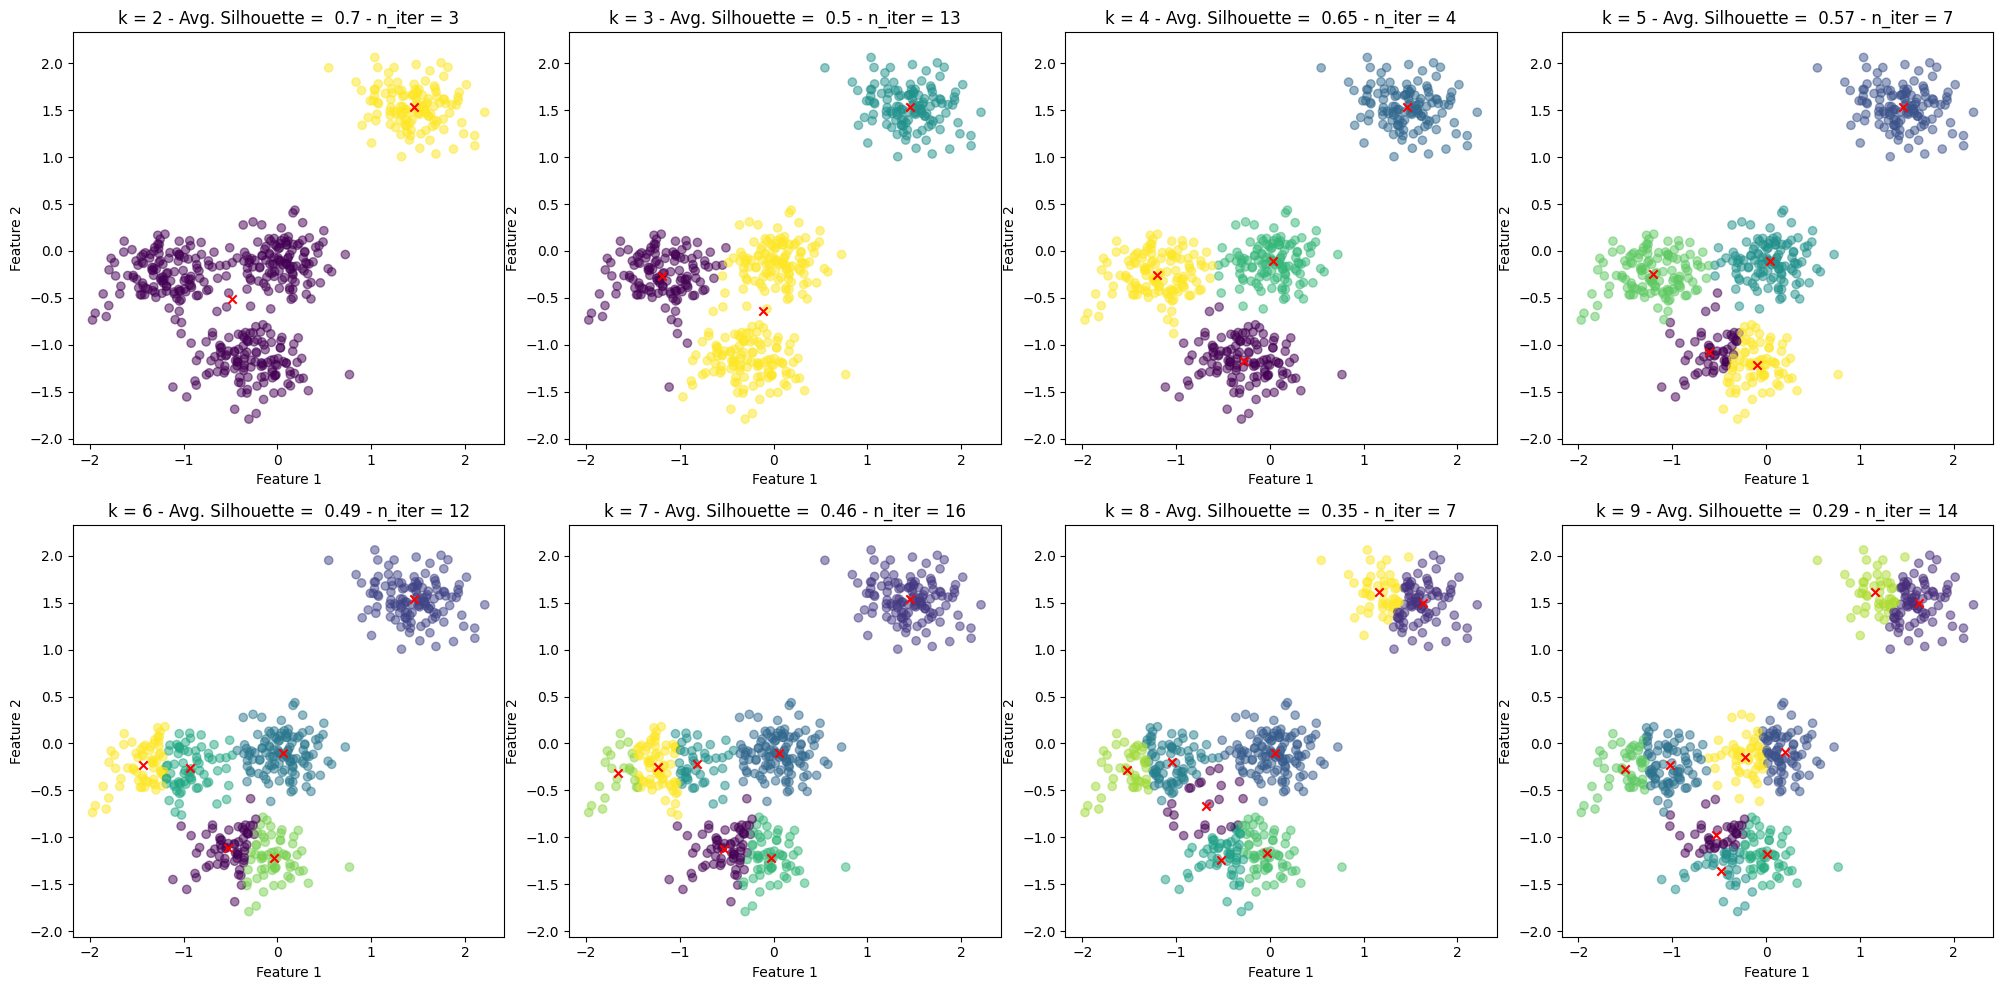

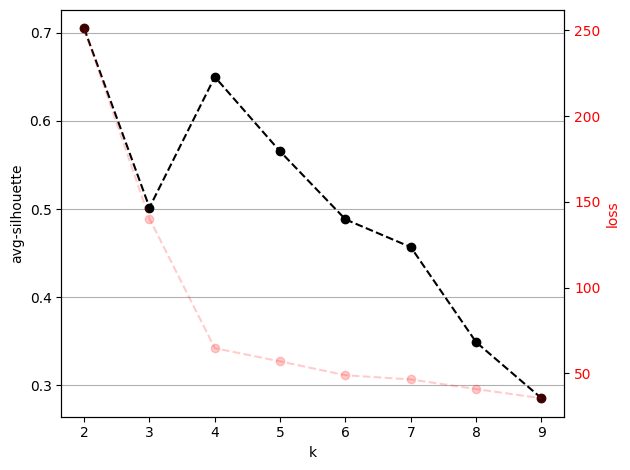

In [11]:
silhouette_list = []
inertia_list = []
f,axes = plt.subplots(2, 4, figsize = (20, 10))
for n_clusters in range(2, 10):
    kmeans = KMeans(n_clusters = n_clusters, random_state = 10, n_init = 'auto')
    y_pred = kmeans.fit_predict(X_scaled)
    
    inertia = kmeans.inertia_
    inertia_list.append(inertia)  
    
    silhouette_avg = silhouette_score(X, y_pred)
    silhouette_list.append(silhouette_avg)

    centers = kmeans.cluster_centers_

    axes[(n_clusters - 2) // 4][(n_clusters - 2) % 4].scatter(X_scaled[:, 0], X_scaled[:, 1], c = y_pred, alpha = 0.5)
    axes[(n_clusters - 2) // 4][(n_clusters - 2) % 4].axis('equal')
    axes[(n_clusters - 2) // 4][(n_clusters - 2) % 4].set_xlabel('Feature 1')
    axes[(n_clusters - 2) // 4][(n_clusters - 2) % 4].set_ylabel('Feature 2')
    axes[(n_clusters - 2) // 4][(n_clusters - 2) % 4].set_title(f'k = {n_clusters} - Avg. Silhouette = {silhouette_avg: .2} - n_iter = {kmeans.n_iter_}' )
    axes[(n_clusters - 2) // 4][(n_clusters - 2) % 4].scatter(centers[:, 0], centers[:, 1], marker = 'x', c = 'r')
    
plt.tight_layout()

fig, ax1 = plt.subplots()
ax1.set_xlabel('k')
ax1.set_ylabel('avg-silhouette', color = 'black')
ax1.plot(range(2, 10), silhouette_list, '--ok')
ax1.tick_params(axis = 'y', labelcolor = 'black')
ax1.grid(axis = 'y')

ax2 = ax1.twinx()  
ax2.set_ylabel('loss', color = 'red')  
ax2.plot(range(2, 10), inertia_list, '--or', alpha = 0.2)
ax2.tick_params(axis = 'y', labelcolor = 'red')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### Note-2: What is the impact of centroids initialization?

By default, sklearn.cluster.KMeans uses the **$k$-means++** initialization strategy: it initializes the centroids to be (generally) distant from each other, leading to probably better results than random initialization.

Furthermore, by default the clustering procedure is iterated with `n_init=10` different random centroid seeds: the final results will be the best output of n_init consecutive runs in terms of inertia. 
From the docs *n_init default value will change in version 1.4 from 10 to 'auto'.* It means that:
- n_init = 10 if using init='random' or init is a callable;
- n_init = 1 if using init='k-means++' or init is an array-like.


In the following we run 
- 100 times, n_init = 1, random initialization, n_cluster = 4
- 100 times, n_init = 1, $k$-means++ initialization, n_cluster = 4

In [12]:
avg_sil_random = [silhouette_score(X,
                                   KMeans(n_clusters = 4, init = 'random', random_state = i, n_init = 1).fit_predict(X))
                  for i in range(100)]

In [13]:
avg_sil_plusplus = [silhouette_score(X,
                                     KMeans(n_clusters = 4, init = 'k-means++', random_state = i, n_init = 1).fit_predict(X)) 
                    for i in range(100)]

In [14]:
import pandas as pd
df = pd.DataFrame({'random': avg_sil_random, 'km++': avg_sil_plusplus})

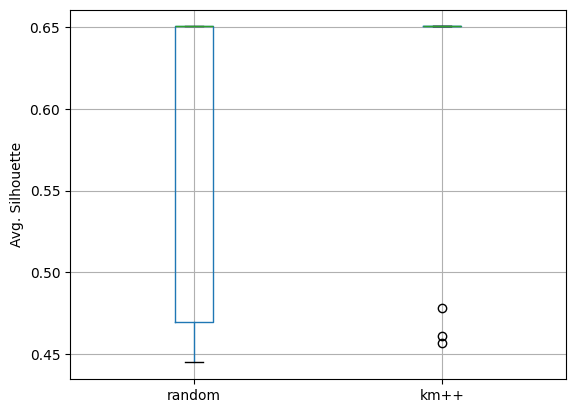

In [15]:
df.boxplot(ylabel = 'Avg. Silhouette')
plt.show()

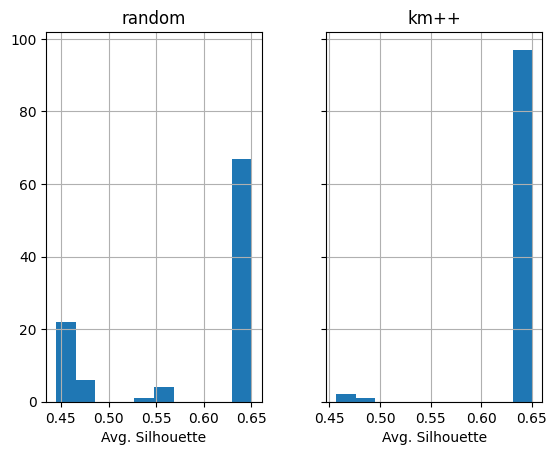

In [16]:
axes = df.hist(sharey = True)
for ax in axes.flatten():
    ax.set_xlabel('Avg. Silhouette')


Random initialization entails lower performance, achieving frequently lower values of average silhouette score.

Let's see some poor result due to (poor) random initialization

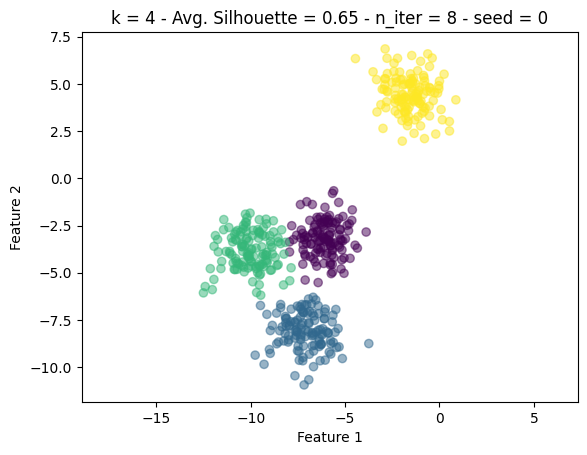

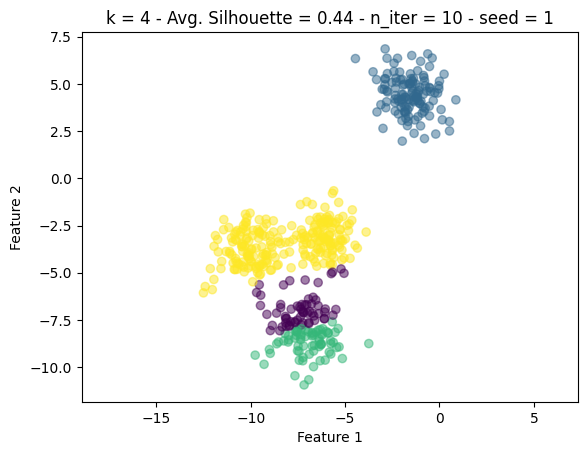

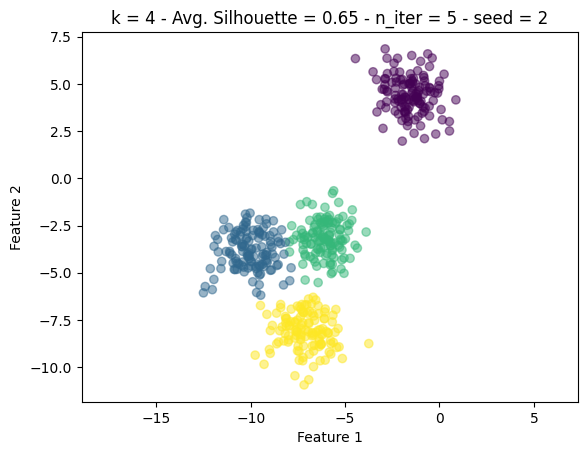

In [17]:
for i in range(3):
    plt.figure()
    kmeans = KMeans(n_clusters = 4, init = 'random', random_state = i, n_init = 1)
    y_pred = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, y_pred)
    plt.scatter(X[:, 0], X[:, 1], c = y_pred, alpha = 0.5)
    plt.axis('equal')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(f'k = 4 - Avg. Silhouette = {silhouette_avg:.2} - n_iter = {kmeans.n_iter_} - seed = {i}' )


# External evaluation metrics


How to evaluate the result of a clustering algorithm:
- through **internal (or intrinsic) metrics**: quality of the modelling itself (compactness and separation), without any ground truth labels (e.g., silhouette score)
- through **external (or extrinsic) metrics**: quality of the modelling based on ground truth labels (e.g., BCubed Precision, BCubed Recall, Adjusted Rand Index)

The whole list of metrics available in scikit-learn is reported [here](https://scikit-learn.org/stable/modules/classes.html#clustering-metrics).

Looking at the trend of average silhouette score, two *peaks* are reached for n_clusters = 2 and n_clusters = 4. The two clustering actually reflects the coarse-grained and fine-grained structure of the dataset, respectively.

The availability of ground truth labels enables an additional evaluation, through the so-called **external metrics**.

In [18]:
kmeans = KMeans(n_clusters = 4, random_state = 10, n_init = 'auto')
y_pred_k4 = kmeans.fit_predict(X)

In [19]:
kmeans = KMeans(n_clusters = 2, random_state = 10, n_init = 'auto')
y_pred_k2 = kmeans.fit_predict(X)


**Adjusted Rand Index (ARI)**
Rand index adjusted for chance.

The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.

- ARI = 0: random labelling
- ARI = 1: perfect agreement between the two clustering 

In [20]:
from sklearn.metrics import adjusted_rand_score as ARI
print(f'kmeans with n_cluster = 4 --> ARI = {ARI(y, y_pred_k4): .03}')
print(f'kmeans with n_cluster = 2 --> ARI = {ARI(y, y_pred_k2): .03}')

kmeans with n_cluster = 4 --> ARI =  0.943
kmeans with n_cluster = 2 --> ARI =  0.332


**Contingency matrix**
- $C_{ij}$ represents the number of samples of class $i$ that are in cluster $j$.

In [21]:
from sklearn.metrics.cluster import contingency_matrix as CM

In [22]:
CM(y, y_pred_k4)

array([[  0, 125,   0,   0],
       [121,   0,   3,   1],
       [  2,   0,   0, 123],
       [  5,   0, 120,   0]])

In [23]:
CM(y, y_pred_k2)

array([[  0, 125],
       [125,   0],
       [125,   0],
       [125,   0]])

**homogeneity, completeness, v-measure**
- *homogeneity*: a property that is satisfied if each cluster contains only members of a single class.
- *completeness*: a property that is satisfied if all members of a given class are assigned to the same cluster.
- *V-measure*: harmonic mean of homogeneity score and completeness score

Note that function homogeneity_score and completeness_score are not symmetric: switching *y_true* with *y_pred* will return the completeness_score and homogeneity_score, respectively.


In [24]:
from sklearn.metrics import homogeneity_completeness_v_measure as HCV

In [25]:
homogeneity_k2, completeness_k2, v_measure_k2 = HCV(y, y_pred_k2)

print(f'homogeneity_k2: {homogeneity_k2: .3}')
print(f'completeness_k2: {completeness_k2: .3}')
print(f'v_measure_k2: {v_measure_k2: .3}')    

homogeneity_k2:  0.406
completeness_k2:  1.0
v_measure_k2:  0.577


- *low homogeneity*: looking at the contingency matrix, we notice that the first cluster (first column) gather objects from three different classes.

- *perfect completeness*: all objects from a given class are assigned to the same cluster (class 1 to cluster 2, class 2-3-4 to cluster 1)


In [26]:
homogeneity_k4, completeness_k4, v_measure_k4 = HCV(y, y_pred_k4)

print(f'homogeneity_k4: {homogeneity_k4: .3}')
print(f'completeness_k4: {completeness_k4: .3}')
print(f'v_measure_k4: {v_measure_k4: .3}')   

homogeneity_k4:  0.926
completeness_k4:  0.926
v_measure_k4:  0.926


## Aside
Blog posts with nice visualization:
- [K-Means](https://www.naftaliharris.com/blog/visualizing-k-means-clustering/)
- [DBSCAN](https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/)